In [1]:
library(cowplot)
library(tidyverse)
library(reticulate)

np <- import("numpy")

i <- np$load("../results/real_world/avg_number.npz", allow_pickle=TRUE)

seven = i$f[['seven']]
three = i$f[['three']]

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA) # get rid of legend panel bg
                          )

color_palette <- c(
#              "MMD\n(linear)" = rgb(165/255,15/255,21/255),
#              "MMD\n(distance)" = rgb(252/255,187/255,161/255),
#              "MMD\n(gaussian)" = rgb(239/255,59/255,44/255),
#              "cMMD\n(linear)" = rgb(165/255,15/255,21/255),
#              "cMMD\n(distance)" = rgb(252/255,187/255,161/255),
             "cMMD\n(gaussian)" = rgb(239/255,59/255,44/255),
#              "HSIC\n(distance)" = rgb(198/255,219/255,239/255),
#              "HSIC\n(linear)" = rgb(8/255,81/255,156/255),
             "HSIC\n(gaussian)" = rgb(107/255,174/255,214/255),
             "TR" = rgb(253/255,191/255,111/255),
             "Pearson" = rgb(106/255,61/255,154/255),
             "PC" = rgb(116/255,196/255,118/255),
             "DC" = rgb(177/255,89/255,40/255)
        )

── Attaching packages ───────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
selected_features <- read_csv('../results/real_world/mnist_scores.csv',
         col_types = 'cicdcddd') %>%
    mutate(features = strsplit(features, ','),
           AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM))

mean_alpha <- selected_features %>%
    unnest(features) %>%
    group_by(AM, features) %>%
    summarize(mean_alpha = mean(alpha)) %>%
    mutate(feature = as.numeric(features)) %>%
    ungroup %>% 
    add_row(AM = 'Raw', feature = 1, mean_alpha = 1) %>%
    mutate(AM = factor(AM, levels = c('Raw', 'cMMD\n(gaussian)', 'DC', 'HSIC\n(gaussian)', 'PC', 'Pearson', 'TR')))

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



In [3]:
get_mnist <- function(mat, label) {
    
    tibble(x = rep(seq(1, 28), 28)) %>%
        mutate(y = sort(x, decreasing = TRUE),
               feature = row_number(),
               weight = as.numeric(mat),
               number = label)
    
}

mnist <- rbind(get_mnist(rep(0, 784), 'none'),
               get_mnist(three, 'three'),
               get_mnist(seven, 'seven'))

options(repr.plot.width=49, repr.plot.height=22)
mnist_img_plot <- ggplot(mnist, aes(x, y, fill = weight)) +
    geom_tile() +
    geom_tile(data = inner_join(mnist, mean_alpha, by = 'feature'), 
              aes(x, y, alpha = 1 - mean_alpha), fill = 'red') +
    scale_fill_gradient(low = 'white', high = 'black') +
    scale_alpha(range = c(0, 1)) +
    labs(alpha = expression(1 - alpha)) +
    facet_grid(number ~ AM) + 
    guides(fill = 'none', alpha = guide_legend(nrow = 1)) +
    theme_void() +
    theme(legend.position = 'bottom',
          legend.text = element_text(size = 50),
          legend.title = element_text(size = 50),
          plot.title = element_text(size = 55),
          strip.text.x = element_text(size = 50),
          strip.text.y = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=2)) +
    theme_transparent

In [4]:
mnist_acc_plot <- selected_features %>%
    group_by(AM, alpha) %>%
    summarize(sd = 1.96 * sd(accuracy, na.rm = TRUE) / sqrt(n()), # fix
              accuracy = mean(accuracy, na.rm = TRUE)) %>%
    ggplot(aes(y = accuracy, x = AM)) +
        geom_bar(aes(alpha = as.character(alpha)),
                 stat = 'identity', position = 'dodge', 
                 fill = 'red', color = 'black', ) +
        geom_errorbar(aes(ymin = accuracy - sd, 
                          ymax = accuracy + sd,
                          group = alpha), 
                      position=position_dodge(width = .9), width = .7, size = 1.5) +
        labs(y = 'Test accuracy', x = 'Association measure', alpha = expression(alpha)) +
        guides(alpha = guide_legend(nrow = 2))+ 
        theme_minimal() +
        theme(text = element_text(size = 50),
              plot.title = element_text(size = 55),
              legend.position = 'bottom') +
        theme_transparent

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



In [5]:
options(repr.plot.width=10, repr.plot.height=7)
mnist_cardinality_plot <- selected_features %>%
    mutate(n_features = lapply(features, length) %>% unlist,
           n_features = ifelse(is.na(features), 0, n_features)) %>%
    group_by(alpha, AM) %>%
    summarize(sd = 1.96 * sd(n_features) / sqrt(n()), # fix
              n_features = mean(n_features)) %>%
    # nudge features to avoid overlaps
    mutate(n_features = ifelse(AM == 'TR', n_features + .6, n_features),
           n_features = ifelse(AM == 'PC', n_features - .6, n_features),
           n_features = ifelse(AM == 'cMMD\n(gaussian)', n_features + .6, n_features),
           n_features = ifelse(AM == 'HSIC\n(gaussian)', n_features - .6, n_features)) %>%
    ggplot(aes(x = alpha, y = n_features, color = AM)) +
        geom_point(size = 10) +
        geom_errorbar(aes(ymin = n_features - sd, ymax = n_features + sd), 
                      width = 0.02, size = 2) +
        geom_line(size = 3) +
        labs(y = '# features', color = 'Association measure', x = expression(alpha)) +
        scale_color_manual(values = color_palette) +
        theme_minimal() +
        theme(text = element_text(size = 50),
              plot.title = element_text(size = 55),
              legend.position = 'bottom') +
        theme_transparent

`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



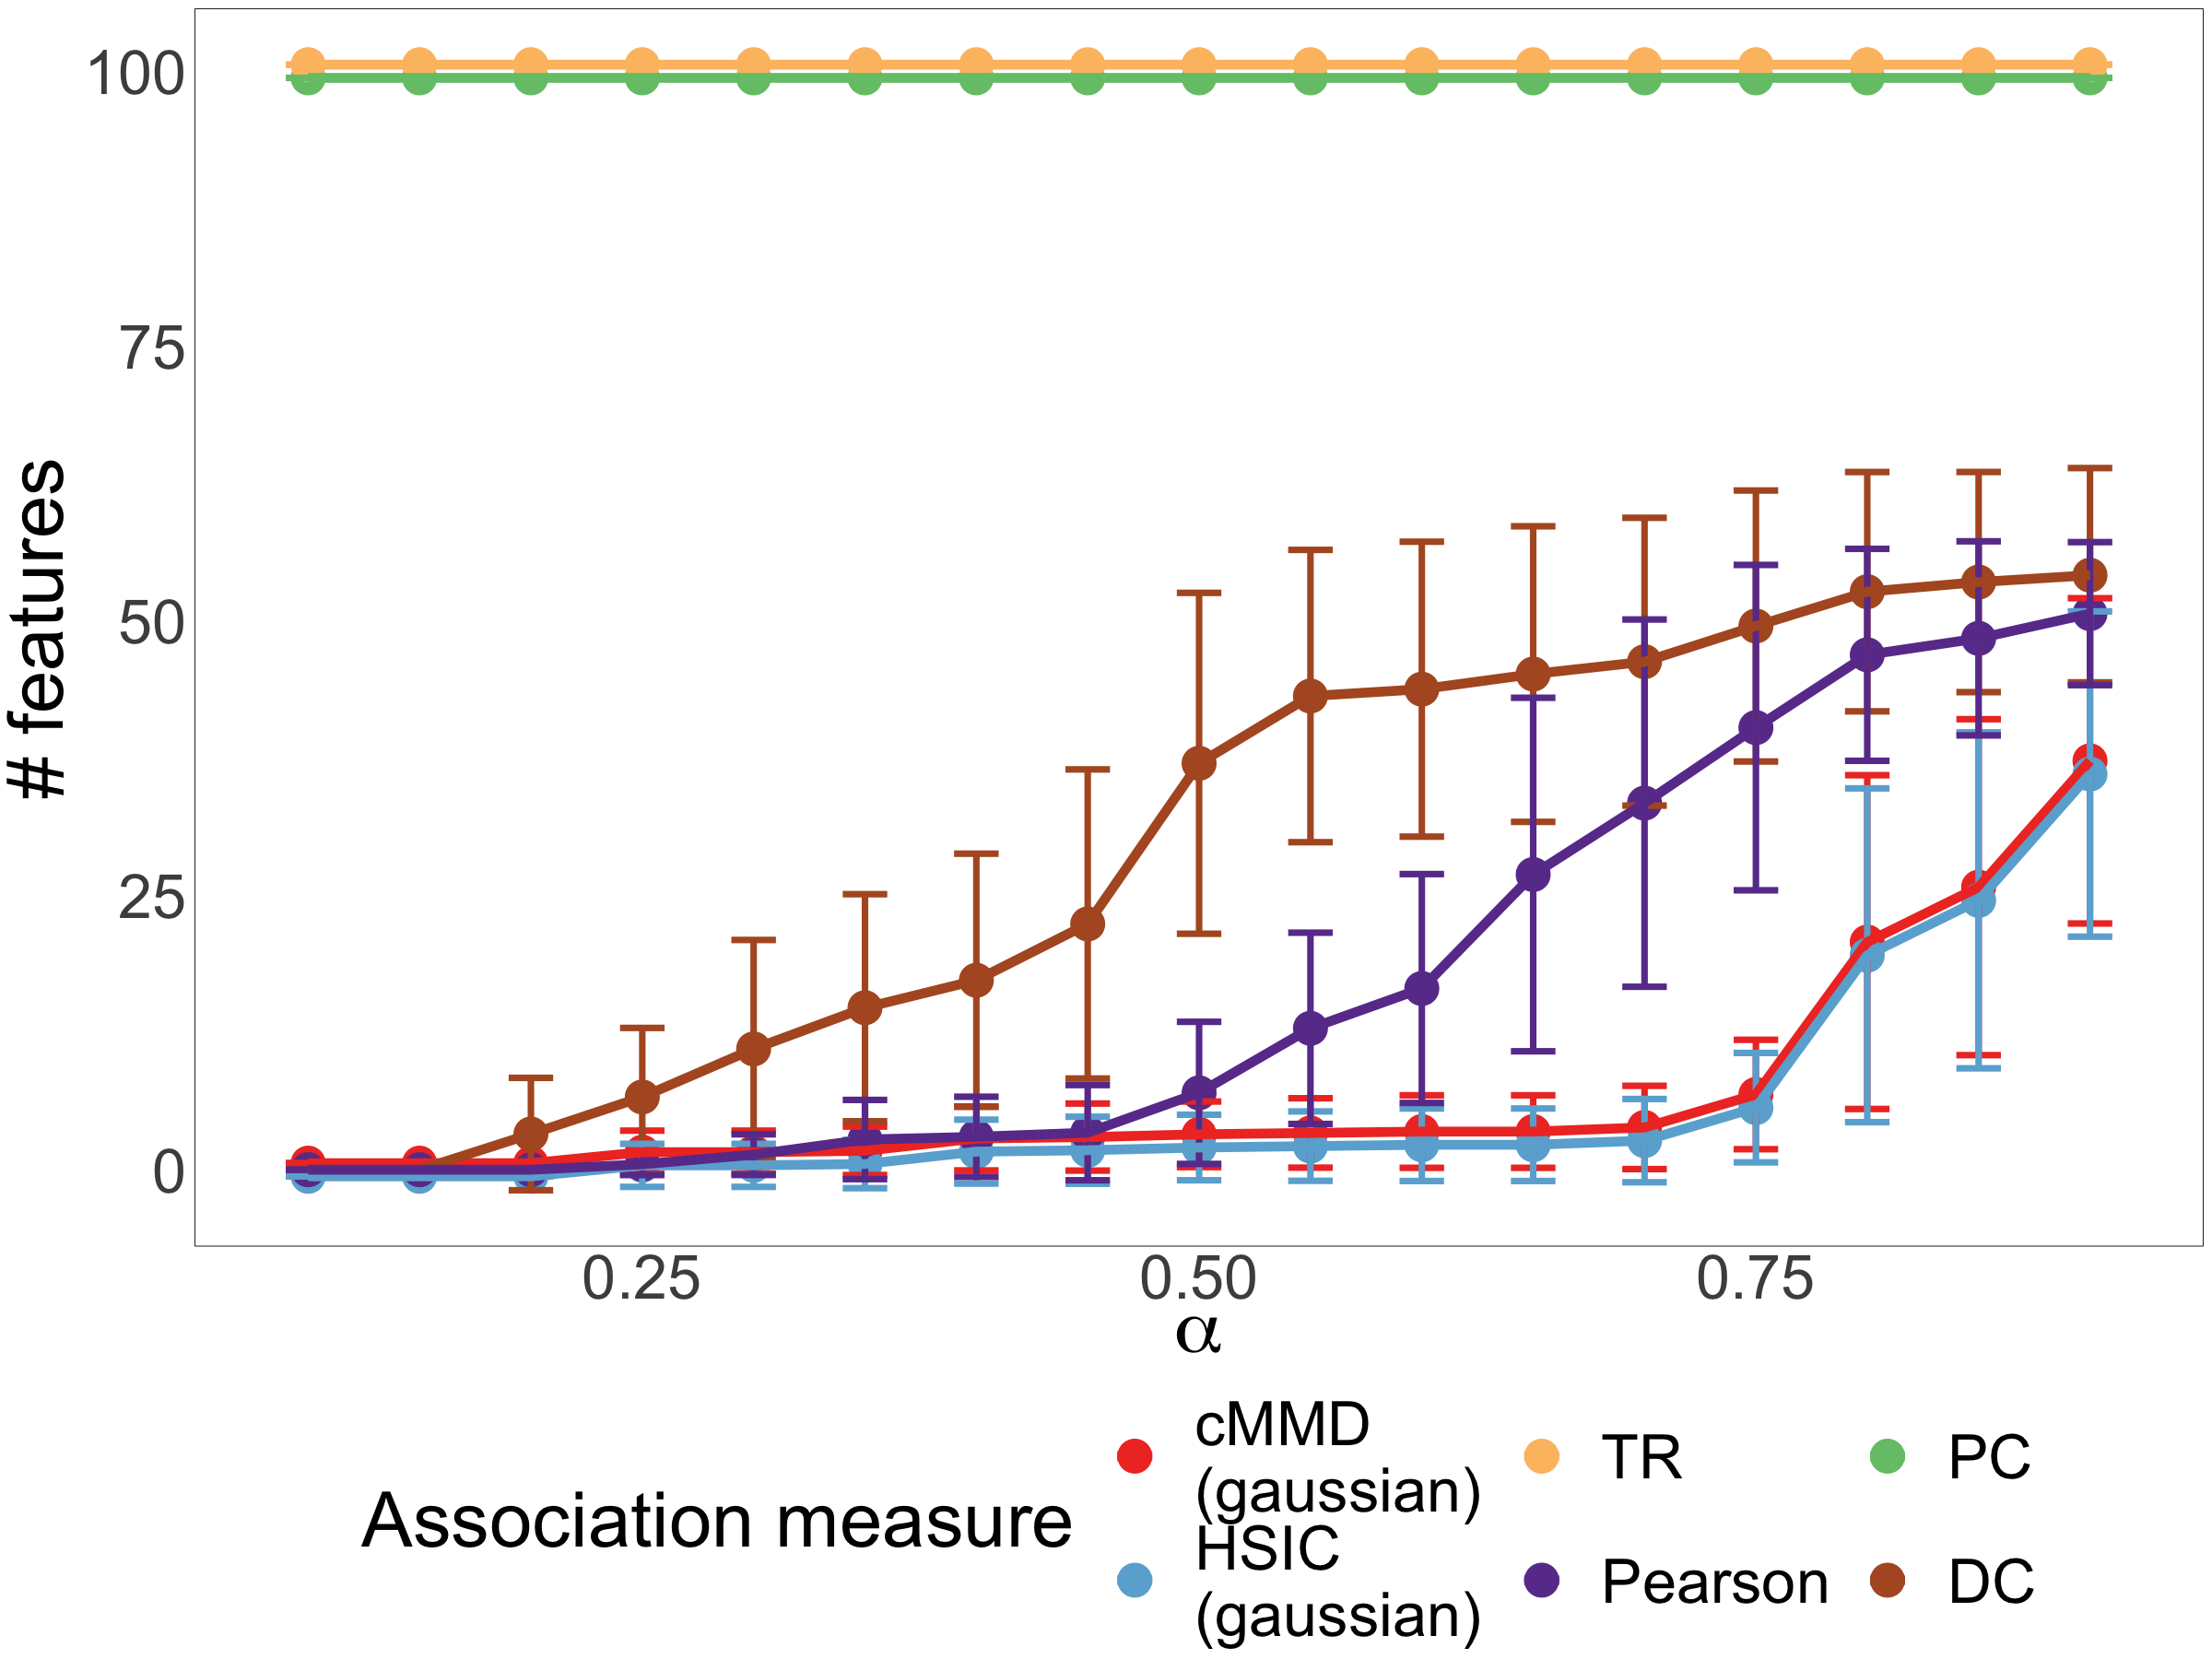

In [6]:
options(repr.plot.width=20, repr.plot.height=15)
mnist_cardinality_plot
ggsave('../results/real_world/mnist_cardinality.pdf', width=45, height=12, bg = "transparent")

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 11 rows containing missing values (geom_bar).”


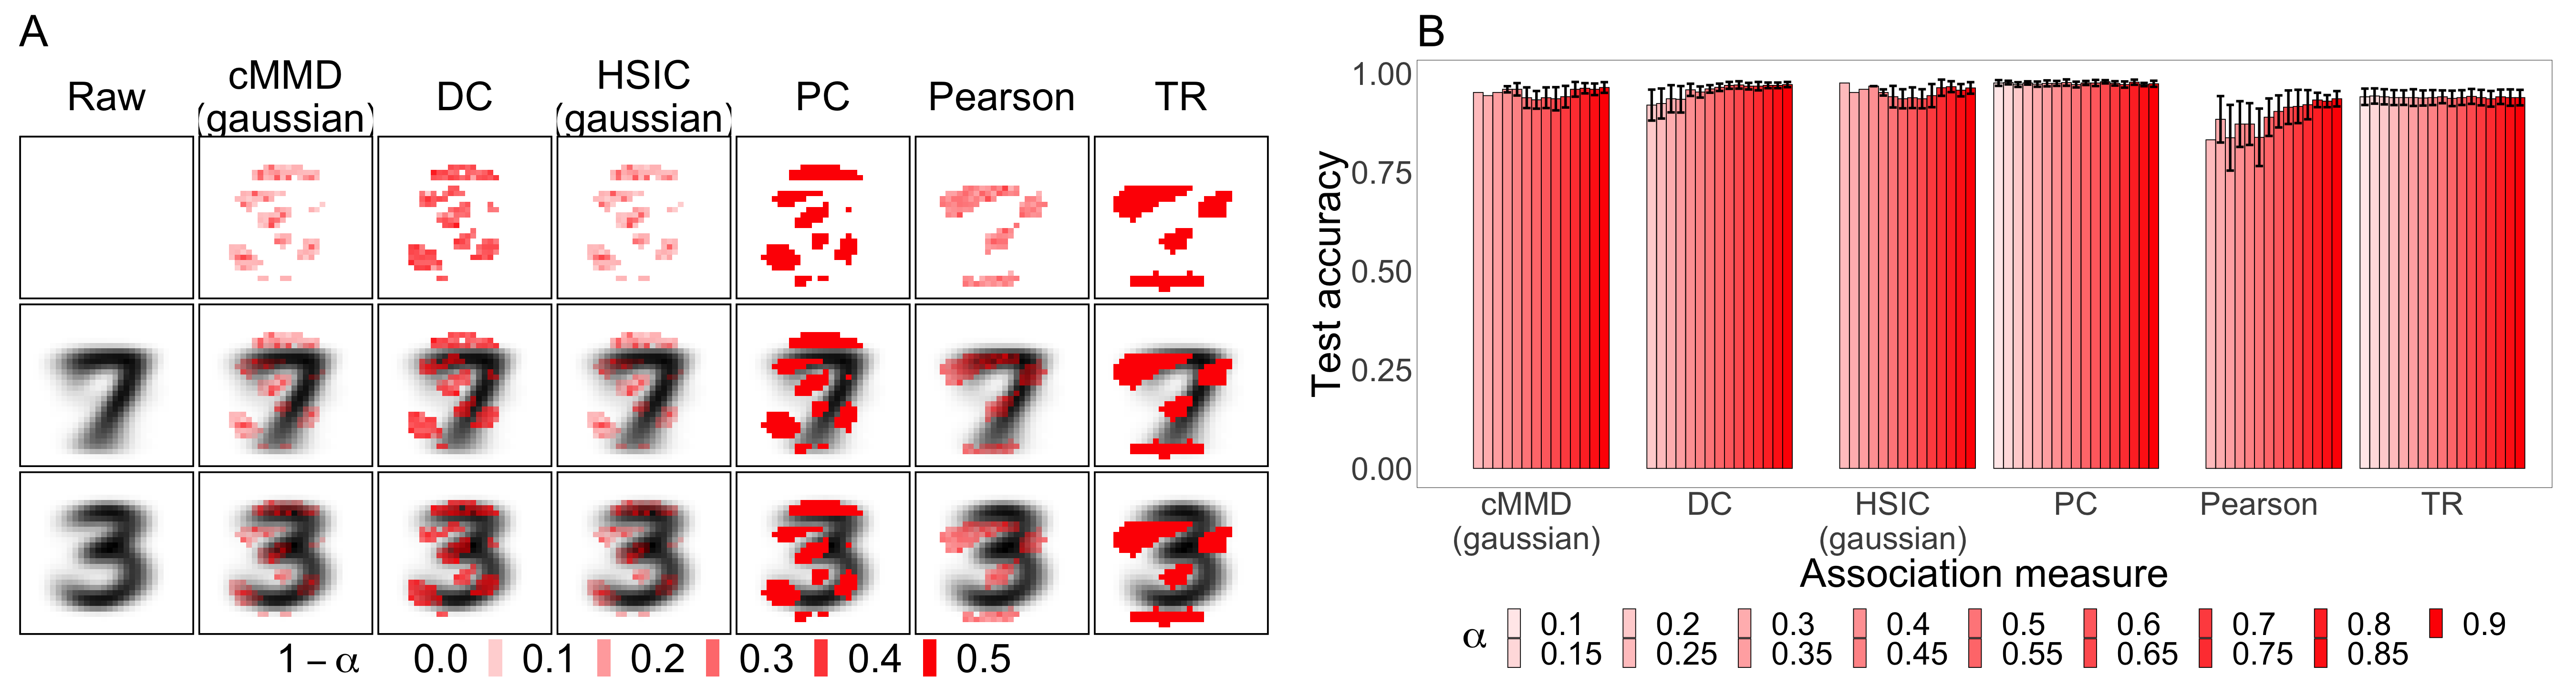

In [7]:
options(repr.plot.width=45, repr.plot.height=12)
plot_grid(mnist_img_plot + ggtitle('A'),
          mnist_acc_plot + ggtitle('B'),
          ncol = 2, scale = 0.97)
ggsave('../results/real_world/mnist.pdf', width=45, height=12, bg = "transparent")